In [ ]:
import pandas as pd

print("Amazon")
df = pd.read_csv('/content/Amazon_stock_data.csv')
print(df.head(20))
print(df.columns)

print("Apple")
df = pd.read_csv('/content/Apple_stock_data.csv')
print(df.head(20))
print(df.columns)

print("Facebook")
df = pd.read_csv('/content/Facebook_stock_data.csv')
print(df.head(20))
print(df.columns)

print("JP Morgan")
df = pd.read_csv('/content/JP Morgan_stock_data.csv')
print(df.head(20))
print(df.columns)

print("Tesla")
df = pd.read_csv('/content/Tesla_stock_data.csv')
print(df.head(20))
print(df.columns)

Amazon
         Price               Close                High                 Low  \
0       Ticker                AMZN                AMZN                AMZN   
1         Date                 NaN                 NaN                 NaN   
2   2015-01-02  15.425999641418457  15.737500190734863  15.347999572753906   
3   2015-01-05   15.10949993133545  15.418999671936035  15.042499542236328   
4   2015-01-06   14.76449966430664  15.149999618530273  14.619000434875488   
5   2015-01-07  14.920999526977539  15.064000129699707  14.766500473022461   
6   2015-01-08   15.02299976348877  15.156999588012695  14.805500030517578   
7   2015-01-09  14.846500396728516  15.143500328063965  14.833999633789062   
8   2015-01-12  14.570500373840332   14.92549991607666   14.46399974822998   
9   2015-01-13  14.737000465393066  15.074999809265137  14.661499977111816   
10  2015-01-14   14.66349983215332  14.795499801635742  14.324999809265137   
11  2015-01-15   14.34749984741211  14.800000190734863  1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

def clean_stock_data(df):
    """
    Cleans the raw stock data format with header rows
    Returns DataFrame with proper columns and numeric types
    """
    # Skip first two rows (header info)
    df = df.iloc[2:].copy()

    # Rename columns based on position
    column_map = {
        0: 'Date',
        1: 'Price',
        2: 'Close',
        3: 'High',
        4: 'Low',
        5: 'Open',
        6: 'Volume'
    }
    df.columns = [column_map.get(i, f'Extra_{i}') for i in range(len(df.columns))]

    # Convert to proper types
    df['Date'] = pd.to_datetime(df['Date'])
    numeric_cols = ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    df.set_index('Date', inplace=True)
    return df

In [11]:
def amazon_strategy(df):
    """Mean-reversion strategy for Amazon"""
    df['SMA_20'] = df['Close'].rolling(20).mean()

    # Calculate RSI
    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Generate signals
    df['signal'] = 0
    df.loc[(df['Close'] < df['SMA_20']) & (df['RSI'] < 30), 'signal'] = 1
    df.loc[df['Close'] > df['SMA_20'] * 1.05, 'signal'] = -1
    return df

def apple_strategy(df):
    """Momentum strategy for Apple"""
    # MACD Calculation
    ema12 = df['Close'].ewm(span=12).mean()
    ema26 = df['Close'].ewm(span=26).mean()
    df['MACD'] = ema12 - ema26
    df['Signal'] = df['MACD'].ewm(span=9).mean()

    # Only use volume if available
    if 'Volume' in df.columns:
        df['Volume_MA'] = df['Volume'].rolling(20).mean()
        volume_condition = df['Volume'] > df['Volume_MA']
    else:
        volume_condition = True  # Always true if no volume data

    # Generate signals
    df['signal'] = 0
    df.loc[(df['MACD'] > df['Signal']) & volume_condition, 'signal'] = 1
    df.loc[df['MACD'] < df['Signal'], 'signal'] = -1
    return df

def facebook_strategy(df):
    """Breakout strategy for Facebook"""
    df['Upper_Band'] = df['Close'].rolling(20).mean() + 2*df['Close'].rolling(20).std()

    # Generate signals
    df['signal'] = 0
    df.loc[df['Close'] > df['Upper_Band'], 'signal'] = 1
    df.loc[df['Close'] < df['Close'].rolling(20).mean(), 'signal'] = -1
    return df

def jpmorgan_strategy(df):
    """Trend following strategy for JP Morgan"""
    df['EMA_50'] = df['Close'].ewm(span=50).mean()
    df['EMA_200'] = df['Close'].ewm(span=200).mean()

    # Generate signals
    df['signal'] = 0
    df.loc[df['EMA_50'] > df['EMA_200'], 'signal'] = 1
    df.loc[df['EMA_50'] < df['EMA_200'], 'signal'] = -1
    return df

def tesla_strategy(df):
    """Volatility strategy for Tesla"""
    df['ATR'] = (df['High'] - df['Low']).rolling(14).mean()
    df['Upper_Vol'] = df['Close'].rolling(20).mean() + 1.5*df['ATR']

    # Generate signals
    df['signal'] = 0
    df.loc[df['Close'] > df['Upper_Vol'], 'signal'] = 1
    df.loc[df['Close'].rolling(5).mean() < df['Close'].rolling(20).mean(), 'signal'] = -1
    return df


Amazon Strategy Results:
+----+---------------------+--------+----------+----------+----------+-----------+
|    | Date                | Type   |    Price |   Shares |      PnL |   Return% |
|----+---------------------+--------+----------+----------+----------+-----------|
|  0 | 2015-03-17 00:00:00 | BUY    |  18.725  |  5340.45 |    nan   |  nan      |
|  1 | 2015-04-24 00:00:00 | SELL   |  22.6325 |  5340.45 |  20867.8 |   20.8678 |
|  2 | 2015-08-24 00:00:00 | BUY    |  23.829  |  5072.3  |    nan   |  nan      |
|  3 | 2015-09-17 00:00:00 | SELL   |  27.3485 |  5072.3  |  38719.8 |   38.7198 |
|  4 | 2015-12-14 00:00:00 | BUY    |  32.9295 |  4212.63 |    nan   |  nan      |
|  5 | 2016-03-01 00:00:00 | SELL   |  28.9625 |  4212.63 |  22008.3 |   22.0083 |
|  6 | 2016-06-24 00:00:00 | BUY    |  35.6265 |  3424.65 |    nan   |  nan      |
|  7 | 2016-09-28 00:00:00 | SELL   |  41.507  |  3424.65 |  42146.9 |   42.1469 |
|  8 | 2016-10-20 00:00:00 | BUY    |  40.7855 |  3485.23 |  

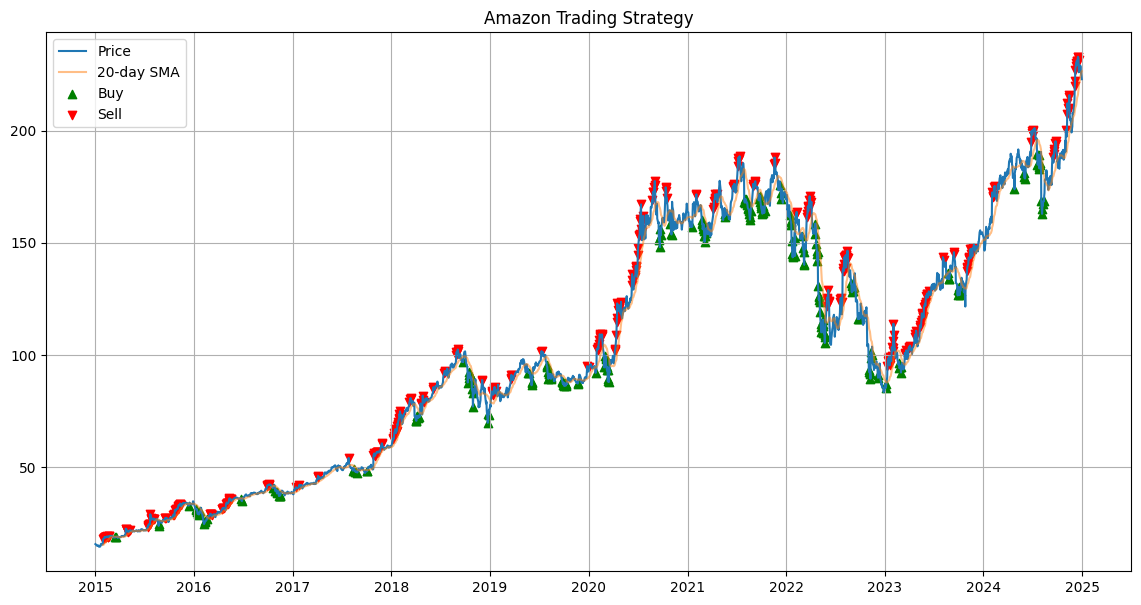


Apple Strategy Results:
+-----+---------------------+--------+----------+----------+-----------+-----------+
|     | Date                | Type   |    Price |   Shares |       PnL |   Return% |
|-----+---------------------+--------+----------+----------+-----------+-----------|
|   0 | 2015-01-08 00:00:00 | BUY    |  24.9477 |  4008.38 |    nan    | nan       |
|   1 | 2015-01-15 00:00:00 | SELL   |  24.4828 |  4008.38 |  -1863.57 |  -1.86357 |
|   2 | 2015-01-22 00:00:00 | BUY    |  25.0189 |  3922.49 |    nan    | nan       |
|   3 | 2015-03-02 00:00:00 | SELL   |  29.0951 |  3922.49 |  14125.3  |  14.1253  |
|   4 | 2015-04-13 00:00:00 | BUY    |  28.7132 |  3974.66 |    nan    | nan       |
|   5 | 2015-04-17 00:00:00 | SELL   |  28.1706 |  3974.66 |  11968.3  |  11.9683  |
|   6 | 2015-04-20 00:00:00 | BUY    |  28.6127 |  3913.23 |    nan    | nan       |
|   7 | 2015-05-05 00:00:00 | SELL   |  28.6864 |  3913.23 |  12256.7  |  12.2567  |
|   8 | 2015-05-18 00:00:00 | BUY    |  

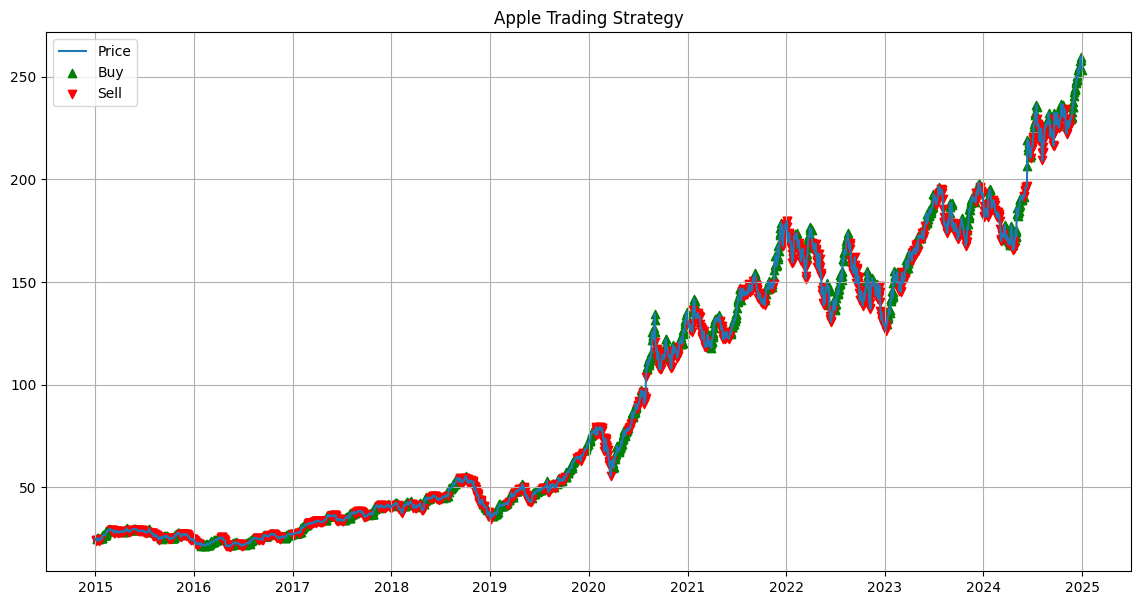


Facebook Strategy Results:
+----+---------------------+--------+----------+----------+------------+------------+
|    | Date                | Type   |    Price |   Shares |        PnL |    Return% |
|----+---------------------+--------+----------+----------+------------+------------|
|  0 | 2015-02-19 00:00:00 | BUY    |  79.4655 | 1258.41  |    nan     | nan        |
|  1 | 2015-03-11 00:00:00 | SELL   |  78.0621 | 1258.41  |  -1766.03  |  -1.76603  |
|  2 | 2015-03-19 00:00:00 | BUY    |  82.6107 | 1189.12  |    nan     | nan        |
|  3 | 2015-04-10 00:00:00 | SELL   |  82.2225 | 1189.12  |  -2227.62  |  -2.22762  |
|  4 | 2015-04-23 00:00:00 | BUY    |  85.1885 | 1147.72  |    nan     | nan        |
|  5 | 2015-04-24 00:00:00 | SELL   |  82.5509 | 1147.72  |  -5254.8   |  -5.2548   |
|  6 | 2015-06-22 00:00:00 | BUY    |  84.5714 | 1120.3   |    nan     | nan        |
|  7 | 2015-08-07 00:00:00 | SELL   |  94.9525 | 1120.3   |   6375.1   |   6.3751   |
|  8 | 2015-10-19 00:00:00

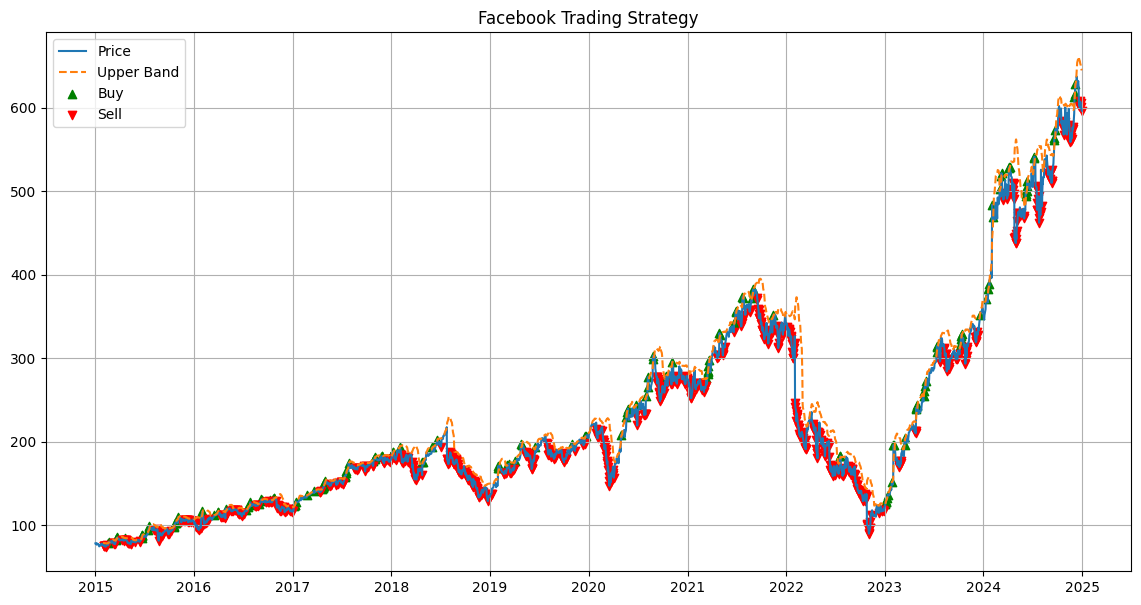


JP Morgan Strategy Results:
+----+---------------------+--------+----------+----------+-----------+-----------+
|    | Date                | Type   |    Price |   Shares |       PnL |   Return% |
|----+---------------------+--------+----------+----------+-----------+-----------|
|  0 | 2015-02-23 00:00:00 | BUY    |  45.2165 |  2211.58 |    nan    | nan       |
|  1 | 2015-09-25 00:00:00 | SELL   |  47.6078 |  2211.58 |   5288.38 |   5.28838 |
|  2 | 2015-11-06 00:00:00 | BUY    |  53.5091 |  1967.67 |    nan    | nan       |
|  3 | 2016-01-15 00:00:00 | SELL   |  44.9252 |  1967.67 | -11602    | -11.602   |
|  4 | 2016-05-19 00:00:00 | BUY    |  50.4856 |  1750.95 |    nan    | nan       |
|  5 | 2018-12-14 00:00:00 | SELL   |  85.1121 |  1750.95 |  49027.3  |  49.0273  |
|  6 | 2019-04-18 00:00:00 | BUY    |  97.4942 |  1528.58 |    nan    | nan       |
|  7 | 2020-03-19 00:00:00 | SELL   |  76.3489 |  1528.58 |  16705.2  |  16.7052  |
|  8 | 2020-11-13 00:00:00 | BUY    | 102.485  

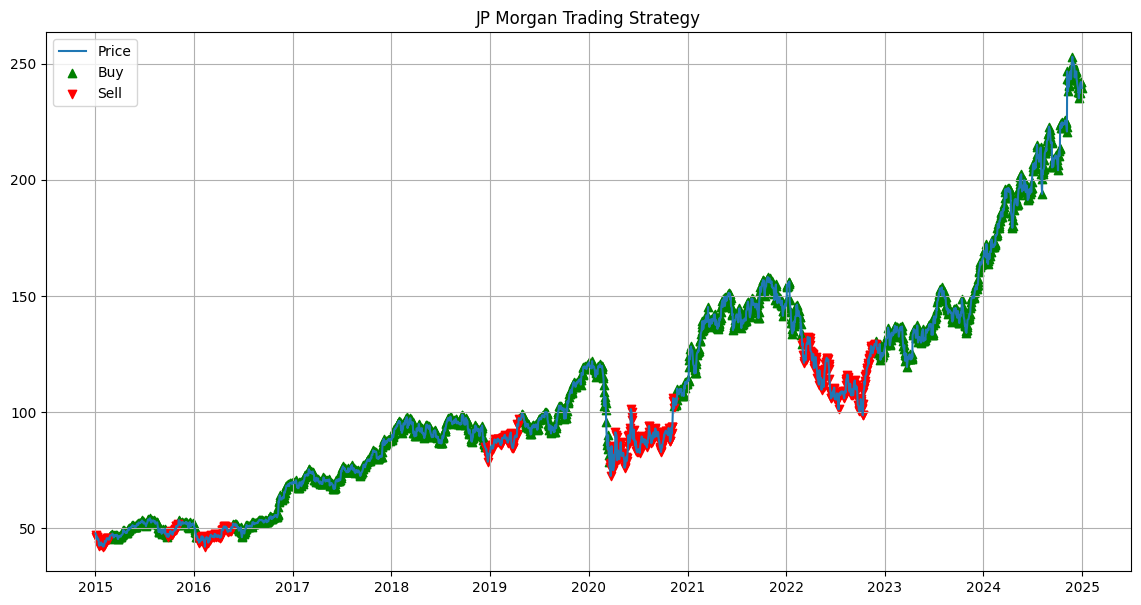


Tesla Strategy Results:
+-----+---------------------+--------+----------+----------+------------------+-------------+
|     | Date                | Type   |    Price |   Shares |              PnL |     Return% |
|-----+---------------------+--------+----------+----------+------------------+-------------|
|   0 | 2015-01-30 00:00:00 | BUY    |  13.8313 |  7229.96 |    nan           |  nan        |
|   1 | 2015-02-17 00:00:00 | SELL   |  13.7133 |  7229.96 |   -853.136       |   -0.853136 |
|   2 | 2015-03-24 00:00:00 | BUY    |  13.586  |  7297.72 |    nan           |  nan        |
|   3 | 2015-03-26 00:00:00 | SELL   |  12.986  |  7297.72 |  -5231.77        |   -5.23177  |
|   4 | 2015-04-07 00:00:00 | BUY    |  13.6707 |  6932.23 |    nan           |  nan        |
|   5 | 2015-07-13 00:00:00 | SELL   |  17.5033 |  6932.23 |  21337.2         |   21.3372   |
|   6 | 2015-07-20 00:00:00 | BUY    |  19.11   |  6349.41 |    nan           |  nan        |
|   7 | 2015-07-27 00:00:00 | SELL 

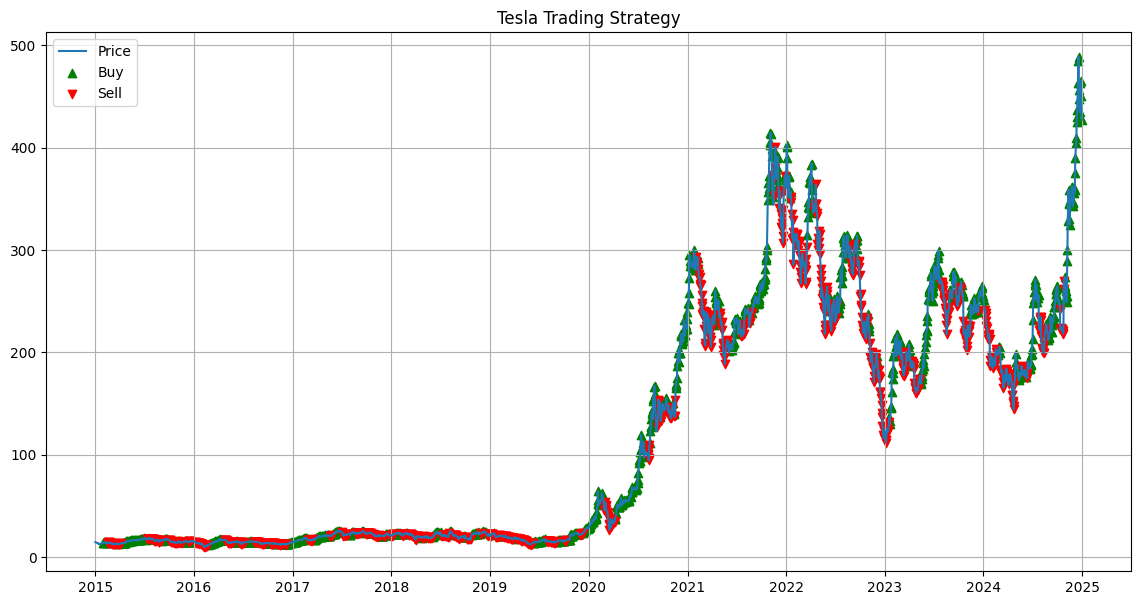


=== FINAL PERFORMANCE SUMMARY ===
+----+-----------+----------------+------------+-------------+--------------+
|    | Stock     |   TotalReturn% |   WinRate% |   NumTrades |   FinalValue |
|----+-----------+----------------+------------+-------------+--------------|
|  0 | Amazon    |         211.13 |      50.00 |          56 |    311133.22 |
|  1 | Apple     |         642.17 |      49.44 |         180 |   1484344.06 |
|  2 | Facebook  |         189.30 |      46.67 |          90 |    289304.24 |
|  3 | JP Morgan |         172.71 |      41.67 |          12 |    545414.00 |
|  4 | Tesla     |        2651.46 |      44.08 |         152 |   5502910.63 |
+----+-----------+----------------+------------+-------------+--------------+


In [12]:
# Backtesting Configuration
INITIAL_CAPITAL = 100000

def backtest_strategy(df, stock_name):
    capital = INITIAL_CAPITAL
    position = 0
    trades = []

    for i in range(1, len(df)):
        current_signal = df['signal'].iloc[i]
        price = df['Close'].iloc[i]

        # Buy Signal
        if current_signal == 1 and position == 0:
            position = capital / price
            capital = 0
            trades.append({
                'Date': df.index[i],
                'Type': 'BUY',
                'Price': price,
                'Shares': position
            })

        # Sell Signal
        elif current_signal == -1 and position > 0:
            capital = position * price
            trades.append({
                'Date': df.index[i],
                'Type': 'SELL',
                'Price': price,
                'Shares': position,
                'PnL': capital - INITIAL_CAPITAL,
                'Return%': (capital/INITIAL_CAPITAL - 1)*100
            })
            position = 0

    # Final Position
    if position > 0:
        capital = position * df['Close'].iloc[-1]
        trades.append({
            'Date': df.index[-1],
            'Type': 'SELL',
            'Price': df['Close'].iloc[-1],
            'Shares': position,
            'PnL': capital - INITIAL_CAPITAL,
            'Return%': (capital/INITIAL_CAPITAL - 1)*100
        })

    # Performance Metrics
    trades_df = pd.DataFrame(trades)
    if not trades_df.empty:
        total_return = trades_df['Return%'].iloc[-1]
        win_rate = (len(trades_df[trades_df['PnL'] > 0])/len(trades_df))*100
    else:
        total_return = 0
        win_rate = 0

    return trades_df, {
        'Stock': stock_name,
        'TotalReturn%': total_return,
        'WinRate%': win_rate,
        'NumTrades': len(trades_df),
        'FinalValue': capital + (position * df['Close'].iloc[-1] if position > 0 else 0)
    }

def plot_results(df, stock_name):
    plt.figure(figsize=(14,7))
    plt.plot(df.index, df['Close'], label='Price')

    # Plot strategy-specific indicators
    if 'SMA_20' in df.columns:
        plt.plot(df.index, df['SMA_20'], label='20-day SMA', alpha=0.5)
    if 'Upper_Band' in df.columns:
        plt.plot(df.index, df['Upper_Band'], label='Upper Band', linestyle='--')

    # Plot signals
    buy_signals = df[df['signal'] == 1]
    sell_signals = df[df['signal'] == -1]
    plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='g', label='Buy')
    plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='r', label='Sell')

    plt.title(f'{stock_name} Trading Strategy')
    plt.legend()
    plt.grid()
    plt.show()

def main():
    # Load and clean all datasets
    stocks = {
        'Amazon': clean_stock_data(pd.read_csv('/content/Amazon_stock_data.csv')),
        'Apple': clean_stock_data(pd.read_csv('/content/Apple_stock_data.csv')),
        'Facebook': clean_stock_data(pd.read_csv('/content/Facebook_stock_data.csv')),
        'JP Morgan': clean_stock_data(pd.read_csv('/content/JP Morgan_stock_data.csv')),
        'Tesla': clean_stock_data(pd.read_csv('/content/Tesla_stock_data.csv'))
    }

    # Apply strategies
    strategies = {
        'Amazon': amazon_strategy,
        'Apple': apple_strategy,
        'Facebook': facebook_strategy,
        'JP Morgan': jpmorgan_strategy,
        'Tesla': tesla_strategy
    }

    results = []
    for name, data in stocks.items():
        df = strategies[name](data)
        trades, metrics = backtest_strategy(df, name)
        results.append(metrics)

        print(f"\n{name} Strategy Results:")
        print(tabulate(trades, headers='keys', tablefmt='psql'))
        plot_results(df, name)

    # Final Performance Report
    print("\n=== FINAL PERFORMANCE SUMMARY ===")
    print(tabulate(pd.DataFrame(results), headers='keys', tablefmt='psql', floatfmt=".2f"))

if __name__ == "__main__":
    main()

<h2>Summary of Trading Results</h2>
<ul>
    <li><strong>Amazon</strong>: Moderate performance with a <strong>50% win rate</strong> and <strong>211.13% total return</strong>.</li>
    <li><strong>Apple</strong>: Strong momentum-based performance with <strong>180 trades</strong>, a <strong>49.44% win rate</strong>, and a <strong>642.17% total return</strong>.</li>
    <li><strong>Facebook</strong>: Breakout strategy delivered <strong>46.67% win rate</strong> and <strong>189.30% total return</strong>.</li>
    <li><strong>JP Morgan</strong>: The most conservative, with the fewest trades (<strong>12</strong>), a <strong>41.67% win rate</strong>, and <strong>172.71% total return</strong>.</li>
    <li><strong>Tesla</strong>: High volatility led to the best performance with <strong>2651.46% return</strong> despite a <strong>44.08% win rate</strong>.</li>
</ul>

<h2>Comments on Results</h2>
<ul>
    <li>Tesla’s volatility-based strategy yielded the highest returns but had a relatively lower win rate, suggesting large gains from a few strong trades.</li>
    <li>Apple’s momentum strategy performed well, balancing a high trade count with a solid return.</li>
    <li>JP Morgan’s trend-following approach was the most conservative, with the fewest trades and lowest returns.</li>
    <li>Mean-reversion strategies (Amazon, Facebook) showed moderate success, indicating potential for optimization.</li>
</ul>

<p>Further tuning of entry/exit conditions and risk management could improve strategy performance.</p>